In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [49]:
!pip install pytesseract
import pytesseract
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageEnhance
from pytesseract import Output

In [50]:
input_path="sample01.png"
img=cv2.imread(input_path,0)
print(img)

[[208 211 210 ...  72  69  71]
 [209 209 209 ...  70  67  70]
 [209 209 208 ...  71  70  70]
 ...
 [202 203 204 ...  65  67  69]
 [204 206 205 ...  66  65  66]
 [207 205 203 ...  66  68  69]]


In [51]:
#Code to display results of the different thresholding tests
def thresholding_tests(input_img,write_img=False):
    input_path=input_img + ".png"
    img=cv2.imread(input_path,0)
    ret,th1=cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
    th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
    ret4,th4 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    titles=["Original Image", "Global Thresholding(v=127)","Adaptive Mean Thresholding","Adaptive Gaussian Thresholding","Otsu's Thresholding"]
    images=[img,th1,th2,th3,th4]
    if(write_img==True):
        cv2.imwrite(input_img+"_Global_Thresholding(v=127).png",th1)
        cv2.imwrite(input_img+"_Adaptive_Mean_Thresholding.png",th2)
        cv2.imwrite(input_img+"_Adaptive_Gaussian.png",th3)
        cv2.imwrite(input_img+"_Otsu_Thresholding.png",th4)
    fig,ax=plt.subplots(figsize=(20,5))
    for i in range(5):
        plt.subplot(2,3,i+1),plt.imshow(images[i],"gray")
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()
        
    

In [52]:
def brightness_contrast_tests(input_img,write_img=False):
    input_path=input_img + ".png"
    img=cv2.imread(input_path,0)
    hist1=cv2.equalizeHist(img)
    clahe=cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
    hist2=clahe.apply(img)
    bright_img=cv2.convertScaleAbs(img,alpha=2,beta=75)
    images=[hist1,hist2,bright_img]
    if(write_img==True):
        cv2.imwrite(input_img+"_Histogram_Eq.png",hist1)
        cv2.imwrite(input_img+"_CHALE_Histogram_Eq.png",hist2)
        cv2.imwrite(input_img+"_Brightness_up.png",bright_img)
    fig,ax=plt.subplots(figsize=(20,10))
    titles=["Histogram Equalization", "CHALE Histogram Equalization","Increase Brightness"]
    for i in range(3):
        plt.subplot(1,3,i+1),plt.imshow(images[i],"gray")
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()
    

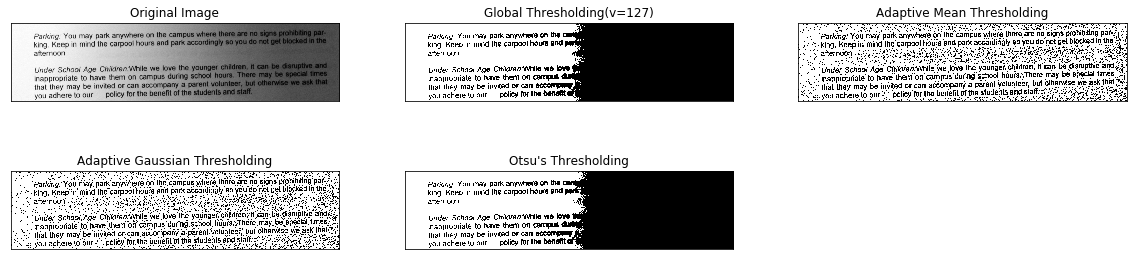

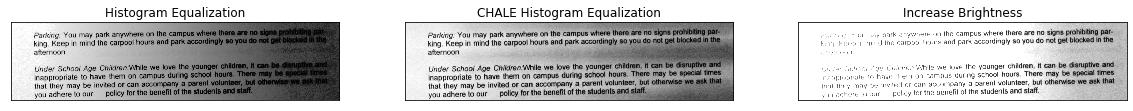

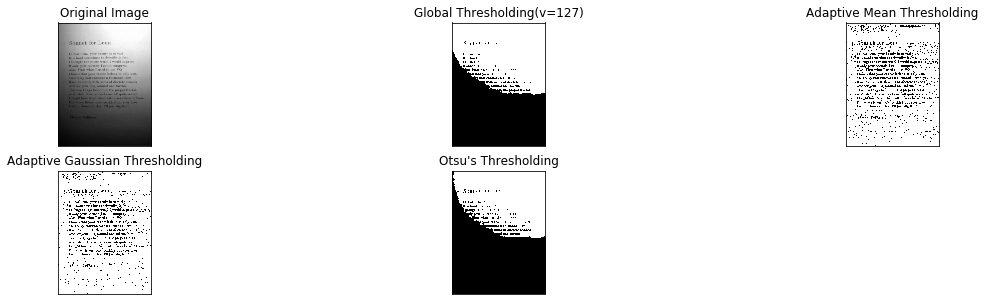

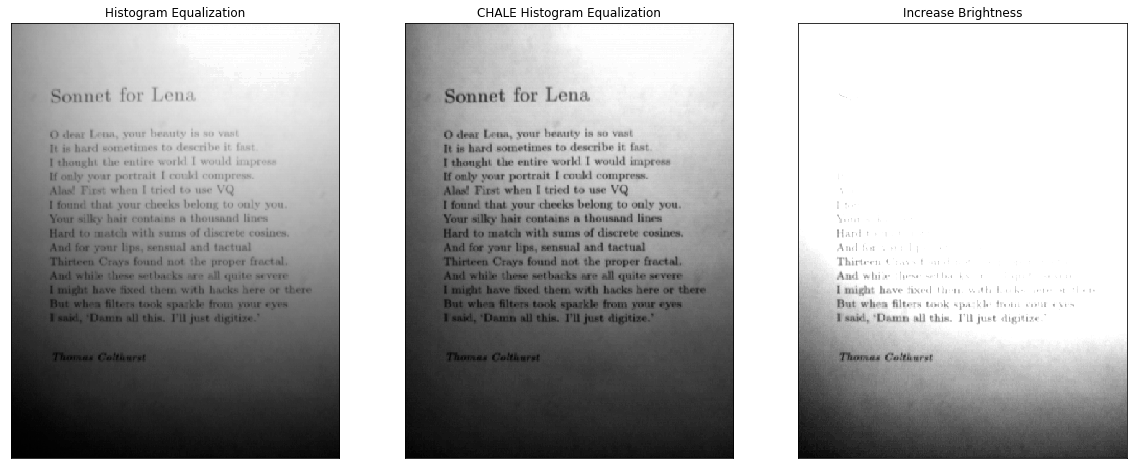

In [53]:
thresholding_tests("sample01",True)
brightness_contrast_tests("sample01",True)
thresholding_tests("sample02",True)
brightness_contrast_tests("sample02",True)

In [54]:
def split_image(input_img,write_images=True):
    input_path=input_img + ".png"
    img=cv2.imread(input_path,0)
    #Global Thresholding
    ret,th1=cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    #Huge median filter to estimate black and white halves
    median=cv2.medianBlur(th1,75)
    rows,cols=median.shape
    #Finding pixel at boundary of black and white image
    total_sum=0
    for i in range(rows):
        first_px_value=int(median[i,0])
        for j in range(cols):
            current_px_value=int(median[i,j])
            diff=abs(first_px_value-current_px_value)
            if(diff==255):
                margin=j
                total_sum+=margin
                break
    bound=int(total_sum/rows)
    #Array slicing to crop image
    crop_img_1=img[0:rows,0:0+bound]
    crop_img_2=img[0:rows,bound:cols]
    if(write_images==True):
        cv2.imwrite(input_img+"_median.png",median)
        cv2.imwrite(input_img+"_crop_1.png",crop_img_1)
        cv2.imwrite(input_img+"_crop_2.png",crop_img_2)
    return([crop_img_1,crop_img_2])

In [55]:
# def adjust_brightness(input_img,output_img):
#     left_img,right_img=split_image(input_img)
#     input_path=input_img + ".png"
#     output_path=output_img + ".png"
#     adjusted=[]
#     enhancer_left = ImageEnhance.Brightness(left_img)
#     enhancer_right = ImageEnhance.Brightness(right_img)
#     factor_left = 1.5 #brightens the image
#     im_output_left = enhancer_left.enhance(factor_left)
#     factor_right=3
#     im_output_right=enhancer_right.enhance(factor_right)
#     vis=np.concatenate((im_output_left,im_output_right),axis=1)
#     cv2.imwrite(output_path,vis)
#     #Separately increasing brightness
#     for img in images:
#         cols,rows=img.shape
#         #Finding average brightness of the image
#         brightness=np.sum(img)/(255^cols^rows)
#         #ratio to scale the image brightness by
#         minimum_brightness=0.5
#         alpha=brightness/minimum_brightness
#         bright_img=cv2.convertScaleAbs(img,alpha=alpha,beta=255*(1-alpha))
        
#         ratio=brightness/minimum_brightness
#         if(ratio>=1):
#             adjusted.append(img)
#         else:
#             img=cv2.convertScaleAbs(img,alpha=1/ratio,beta=0)
#             adjusted.append(img)
#     #rejoining the images
#     vis=np.concatenate((adjusted[0],adjusted[1]),axis=1)
#     cv2.imwrite(output_path,vis)
#     return

In [56]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

In [57]:
def adjust_brightness(left_img,right_img,output_img):
    left_path=left_img + ".png"
    right_path=right_img + ".png"
    output_path=output_img + ".png"
    
    im_left = Image.open(left_path)
    im_right= Image.open(right_path)
    enhancer_left = ImageEnhance.Brightness(im_left)
    enhancer_right = ImageEnhance.Brightness(im_right)
    factor_left = 1.5 #brightens the image
    im_output_left = enhancer_left.enhance(factor_left)
    factor_right = 3.0 #brightens the image
    im_output_right = enhancer_right.enhance(factor_right)
    get_concat_h(im_output_left, im_output_right).save(output_path)
    return

    

In [58]:
split_image("sample01")
split_image("sample02")

[array([[135, 137, 137, ..., 161, 161, 161],
        [135, 137, 137, ..., 161, 161, 161],
        [137, 137, 137, ..., 161, 161, 161],
        ...,
        [ 29,  29,  29, ...,  31,  31,  31],
        [ 29,  29,  29, ...,  31,  31,  31],
        [ 29,  29,  29, ...,  29,  29,  29]], dtype=uint8),
 array([[161, 161, 163, ..., 243, 243, 243],
        [161, 161, 163, ..., 243, 243, 243],
        [161, 161, 163, ..., 243, 245, 245],
        ...,
        [ 31,  31,  31, ...,  37,  37,  37],
        [ 31,  31,  31, ...,  37,  37,  37],
        [ 29,  29,  29, ...,  35,  35,  35]], dtype=uint8)]

In [59]:
adjust_brightness("sample01_crop_1","sample01_crop_2","sample01_processed")
adjust_brightness("sample02_crop_1","sample02_crop_2","sample02_processed")

In [60]:
def draw_bbox_all(input_img,output_img):
    input_path=input_img + ".png"
    output_path=output_img + "_all.png"
    img=cv2.imread(input_path)
    d=pytesseract.image_to_data(Image.open(input_path), output_type=Output.DICT)
    n_boxes=len(d['level'])
    for i in range(n_boxes):
        (x,y,w,h)= (d['left'][i],d['top'][i],d['width'][i],d['height'][i])
        cv2.rectangle(img, (x,y),(x+w,y+h),(0,255,0),2)
    cv2.imwrite(output_path,img)
    return

In [61]:
def draw_bbox_filtered(input_img,output_img,conf_level=70):
    input_path=input_img + ".png"
    output_path=output_img + "_filtered.png"
    img=cv2.imread(input_path)
    d=pytesseract.image_to_data(Image.open(input_path), output_type=Output.DICT)
    n_boxes=len(d['level'])
    for i in range(n_boxes):
        #confidence over 70% and not blank text
        if((int(d['conf'][i])>conf_level)and d['text'][i]!=''):
            (x,y,w,h)= (d['left'][i],d['top'][i],d['width'][i],d['height'][i])
            cv2.rectangle(img, (x,y),(x+w,y+h),(0,255,0),2)
    cv2.imwrite(output_path,img)
    return

#Displaying the text with the same conditions as above
def print_text(input_img,conf_level=70):
    input_path=input_img + ".png"
    img=cv2.imread(input_path)
    d=pytesseract.image_to_data(Image.open(input_path), output_type=Output.DICT)
    n_boxes=len(d['level'])
    for i in range(n_boxes):
        if((int(d['conf'][i])>conf_level)and d['text'][i]!=''):
            text+=d['text'][i]+" "
    print(text)
            

In [62]:
def adjust_brightness_2(input_img,output_img):
    input_path=input_img + ".png"
    output_path=output_img + ".png"
    #read the image
    im = Image.open(input_path)

    #image brightness enhancer
    enhancer = ImageEnhance.Brightness(im)

    factor = 1.5 #brightens the image
    im_output = enhancer.enhance(factor)
    im_output.save(output_path)

In [63]:
img=cv2.imread("sample02_cropped.jpg",0)
clahe=cv2.createCLAHE(clipLimit=15.0,tileGridSize=(12,12))
hist2=clahe.apply(img)
cv2.imwrite("sample02_CHALE.png",hist2)

True

In [64]:
adjust_brightness_2("sample02_CHALE","sample02_CHALE_processed")

In [65]:
from tesserocr import PyTessBaseAPI
api = PyTessBaseAPI(path='tessdata-master/tessdata-master', lang='eng')
try:
    api.SetImageFile('sample01_processed.png')
    print(api.GetUTF8Text())
finally:
    api.End()

Parking’ You may park anywhere on the campus where there are no signs prohibiting par-
king. Keep in mind the carpool hours and park accordingly so you do not get blocked in the
afternoon

Under School Age Children:While we love the younger children, it can be disruptive and
inappropriate to have them on campus during school hours. There may be special times
that they may be invited or can accompany a parent volunteer, but otherwise we ask that
you adhere to our  policy for the benefit of the students and staff.



In [66]:
from tesserocr import PyTessBaseAPI
api = PyTessBaseAPI(path='tessdata-master/tessdata-master', lang='eng')
try:
    api.SetImageFile('sample02_CHALE_processed.png')
    print(api.GetUTF8Text())
finally:
    api.End()

Sonnet for Lena

»
"0 dear Loun, yous beatity s so vast

Tt in hard sometimes to describe it fast.

1 thought the entire world | would impress

H only your portrait | could compress.

Alas! First when 1 tried to use VQ

1 found that your cheeks belong to only you.
Your silky hait contains & thousand lines -t
Hard to match with sums of discrete cosines.
Aud for your lips, sensual and tactual

Thirteen Crays found not the proper fractal.
And while these sethacks are all quite sovere

1 might have fixed them with hacks here or thers
But when filters took spackle from your eyes

¥ wnbl, ‘Dasin all thin, T just digitise.”

3

Haea

Colthwest

    



In [69]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
draw_bbox_all('sample02_CHALE_processed','sample02_CHALE_processed_box')

In [76]:
draw_bbox_filtered('sample02_CHALE_processed_box_all','sample02_CHALE_processed_box_all',conf_level=40)

In [77]:
print(pytesseract.image_to_data(Image.open("sample02_CHALE_processed_box_all.png")))

level	page_num	block_num	par_num	line_num	word_num	left	top	width	height	conf	text
1	1	0	0	0	0	0	0	485	510	-1	
2	1	1	0	0	0	11	338	468	96	-1	
3	1	1	1	0	0	11	338	468	96	-1	
4	1	1	1	1	0	11	338	454	17	-1	
5	1	1	1	1	1	11	339	37	15	77	And
5	1	1	1	1	2	59	338	45	16	66	hile
5	1	1	1	1	3	117	339	42	15	60	these
5	1	1	1	1	4	172	334	73	30	55	setbacks
5	1	1	1	1	5	252	334	28	30	72	jare
5	1	1	1	1	6	289	334	31	30	13	(all)
5	1	1	1	1	7	327	334	44	30	45	(quite
5	1	1	1	1	8	382	334	60	30	55	severe)
4	1	1	1	2	0	11	362	468	20	-1	
5	1	1	1	2	1	11	364	4	14	42	T
5	1	1	1	2	2	24	363	52	19	52	wight
5	1	1	1	2	3	86	358	39	29	95	have
5	1	1	1	2	4	135	358	44	29	0	fixed
5	1	1	1	2	5	190	358	47	29	66	(hem)
5	1	1	1	2	6	246	358	39	29	80	with
5	1	1	1	2	7	298	364	50	15	35	hacks!
5	1	1	1	2	8	359	362	120	18	78	bere
5	1	1	1	2	9	403	358	20	29	93	pr
5	1	1	1	2	10	432	362	47	18	84	(here
4	1	1	1	3	0	12	389	425	19	-1	
5	1	1	1	3	1	12	389	31	16	82	Bat
5	1	1	1	3	2	55	391	47	13	10	whea
5	1	1	1	3	3	112	382	54	32	0	filters
5	1	1	1	3	4	173	382	